## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [19]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "無"

In [20]:
train, test = keras.datasets.cifar10.load_data()

In [21]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [22]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [23]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])

    return model

In [24]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [25]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
#採用categorical cross entropy 的loss方法如下
#keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)      
def combined_loss(gamma=2.,alpha=4.,fl_wgt=0.3,ce_wgt=0.7):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out)) #crossentropy
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))       
        fl = tf.multiply(alpha, tf.multiply(weight, ce)) #focal loss
        reduced_fl = tf.reduce_max(fl, axis=1)
         
        ctlce=keras.losses.categorical_crossentropy(y_true, y_pred)
        return (tf.reduce_mean(reduced_fl)*fl_wgt)+(ctlce*ce_wgt)
    return focal_loss_fixed
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [26]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss( fl_wgt=1-ce_w ,ce_wgt=ce_w ), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128) 

50000/50000 [==============================] - 5s 93us/step - loss: 0.1091 - acc: 0.9892 - val_loss: 6.2215 - val_acc: 0.4802
Epoch 50/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.1008 - acc: 0.9906 - val_loss: 6.5152 - val_acc: 0.4769
Numbers of exp: 1, ce_weight: 0.30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256) 

Epoch 48/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.1706 - acc: 0.9829 - val_loss: 4.9487 - val_acc: 0.4729
Epoch 49/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.1594 - acc: 0.9850 - val_loss: 5.0417 - val_acc: 0.4750
Epoch 50/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.1477 - acc: 0.9874 - val_loss: 5.0165 - val_acc: 0.4794
Numbers of exp: 2, ce_weight: 0.50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)  

50000/50000 [==============================] - 5s 93us/step - loss: 0.2566 - acc: 0.9649 - val_loss: 3.9543 - val_acc: 0.4868
Epoch 47/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.2424 - acc: 0.9678 - val_loss: 3.9509 - val_acc: 0.4848
Epoch 48/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.2251 - acc: 0.9723 - val_loss: 4.0715 - val_acc: 0.4787
Epoch 49/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.2098 - acc: 0.9764 - val_loss: 4.0925 - val_acc: 0.4820
Epoch 50/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.1962 - acc: 0.9792 - val_loss: 4.1441 - val_acc: 0.4800
Numbers of exp: 3, ce_weight: 0.70
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)  

Epoch 45/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.3798 - acc: 0.9305 - val_loss: 2.9233 - val_acc: 0.4771
Epoch 46/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.3606 - acc: 0.9370 - val_loss: 2.9815 - val_acc: 0.4817
Epoch 47/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.3390 - acc: 0.9433 - val_loss: 3.0154 - val_acc: 0.4770
Epoch 48/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.3208 - acc: 0.9474 - val_loss: 3.0117 - val_acc: 0.4808
Epoch 49/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.3032 - acc: 0.9523 - val_loss: 3.0790 - val_acc: 0.4702
Epoch 50/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.2874 - acc: 0.9569 - val_loss: 3.0797 - val_acc: 0.4809
Numbers of exp: 4, ce_weight: 1.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input

50000/50000 [==============================] - 5s 93us/step - loss: 0.6145 - acc: 0.8142 - val_loss: 1.5989 - val_acc: 0.4907
Epoch 44/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.5961 - acc: 0.8215 - val_loss: 1.5985 - val_acc: 0.4938
Epoch 45/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.5785 - acc: 0.8283 - val_loss: 1.6067 - val_acc: 0.4928
Epoch 46/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.5619 - acc: 0.8356 - val_loss: 1.6190 - val_acc: 0.4977
Epoch 47/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.5434 - acc: 0.8423 - val_loss: 1.6448 - val_acc: 0.4888
Epoch 48/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.5286 - acc: 0.8479 - val_loss: 1.6483 - val_acc: 0.4942
Epoch 49/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.5139 - acc: 0.8527 - val_loss: 1.6598 - val_acc: 0.4935
Epoch 50/50
50000/50000 [=====================

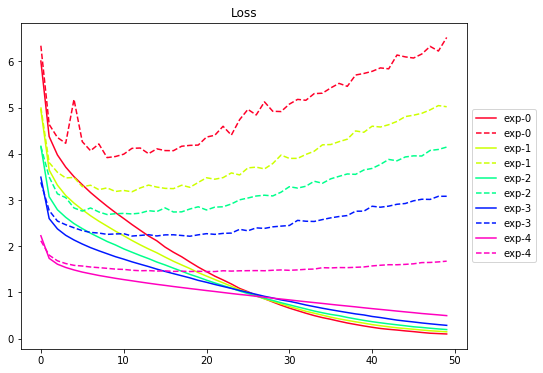

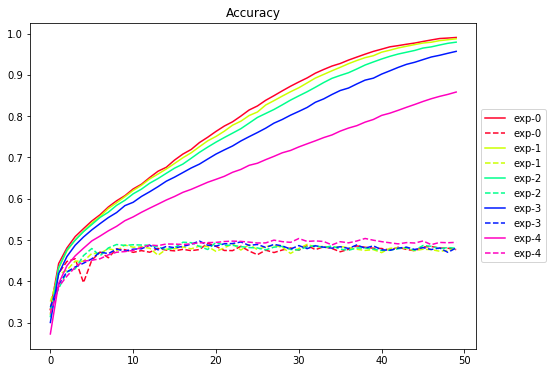

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()